# Car Price Prediction

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from missingno import matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import regularizers
from kerastuner.tuners import RandomSearch

C:\Users\sagop\AppData\Local\Temp\ipykernel_23508\2440610207.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Предварительная обработка

In [2]:
df = pd.read_csv('CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
car_ID,205.0,103.000000,59.322565,1.00,52.00,103.00,154.00,205.00
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [5]:
target = df['price']
df = df.drop(columns=['car_ID', 'price'])

Визуализация пропусков

<Axes: >

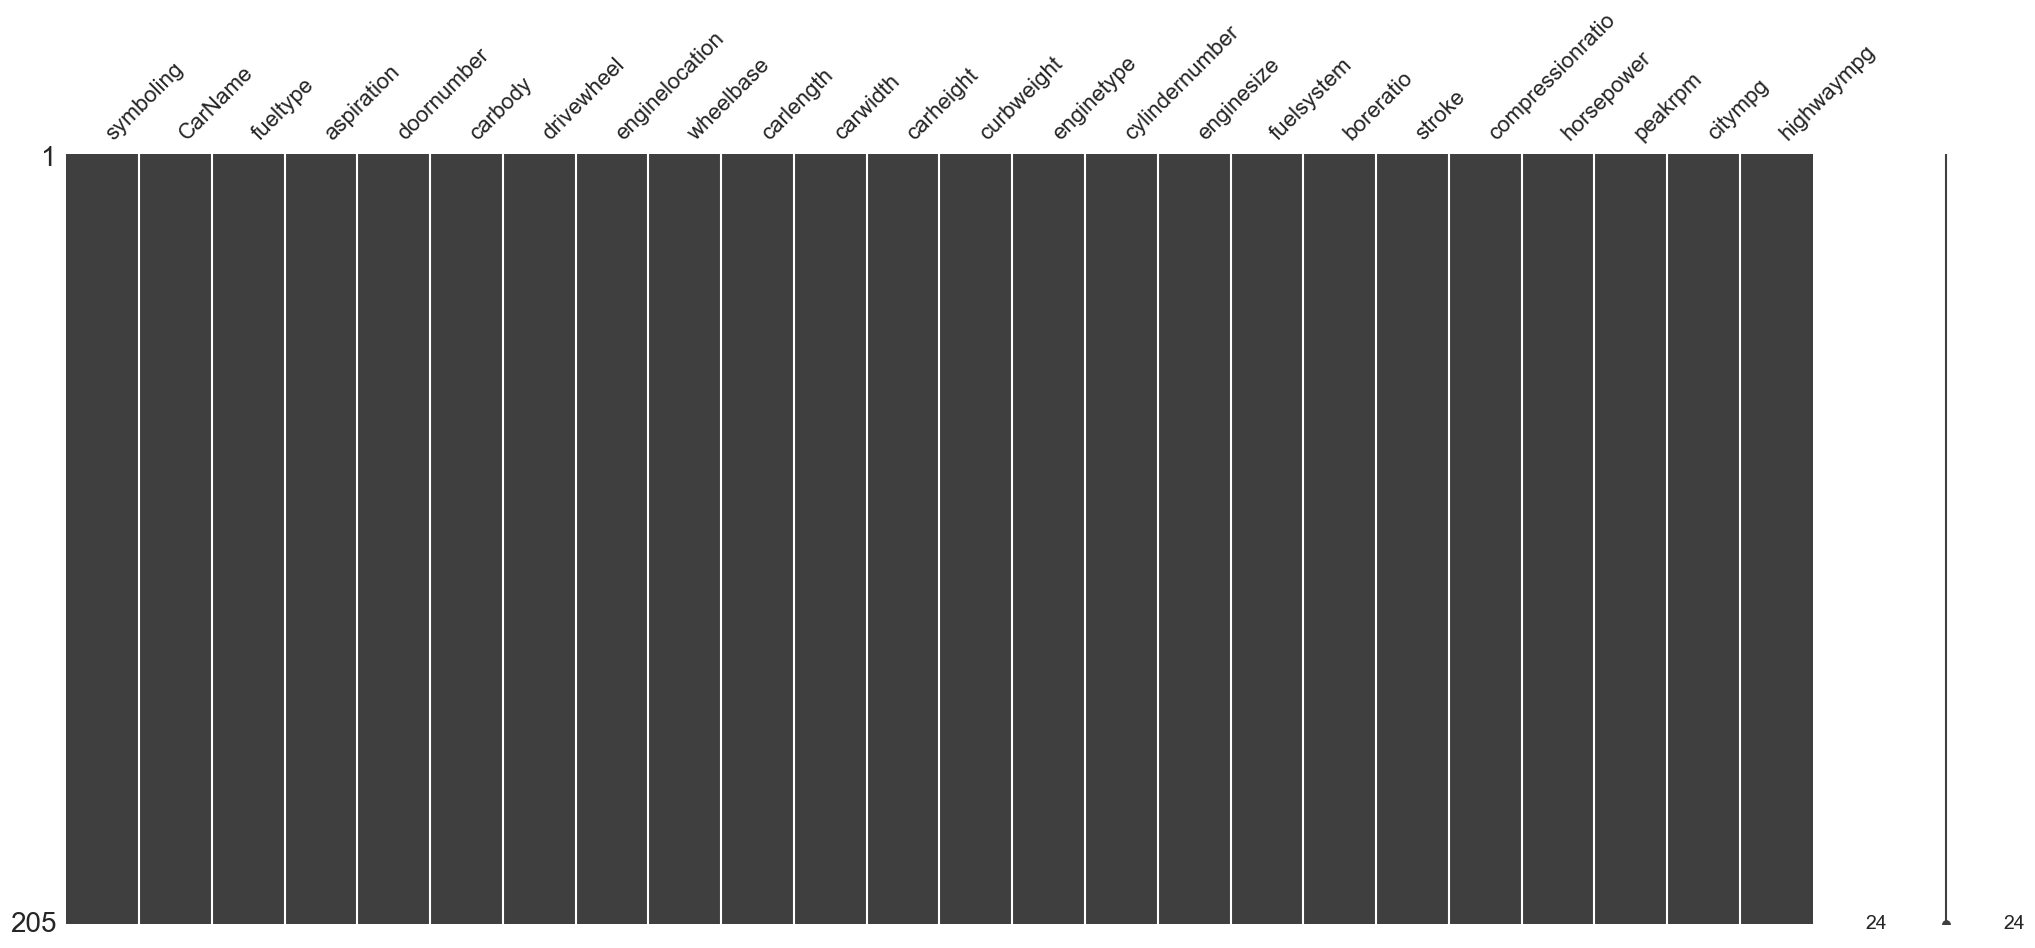

In [6]:
matrix(df)

Стандартизация данных

In [7]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

categorical_features = df.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(df[categorical_features])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df, df_encoded], axis=1)
df.drop(categorical_features, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Columns: 189 entries, symboling to fuelsystem_spfi
dtypes: float64(182), int64(7)
memory usage: 302.8 KB


Выбросы данных в датасете

In [8]:
binary_columns = df.columns[df.isin([0, 1]).all()]

df_check = df.drop(columns=binary_columns)

def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

for column in df_check.columns:
    if pd.api.types.is_numeric_dtype(df_check[column]):
        outliers = detect_outliers(df_check[column])
        print(f"Количество выбросов в столбце '{column}': {outliers.sum()} ({round((outliers.sum() / df_check[column].size), 2)})")

Количество выбросов в столбце 'symboling': 0 (0.0)
Количество выбросов в столбце 'wheelbase': 3 (0.01)
Количество выбросов в столбце 'carlength': 1 (0.0)
Количество выбросов в столбце 'carwidth': 8 (0.04)
Количество выбросов в столбце 'carheight': 0 (0.0)
Количество выбросов в столбце 'curbweight': 0 (0.0)
Количество выбросов в столбце 'enginesize': 10 (0.05)
Количество выбросов в столбце 'boreratio': 0 (0.0)
Количество выбросов в столбце 'stroke': 20 (0.1)
Количество выбросов в столбце 'compressionratio': 28 (0.14)
Количество выбросов в столбце 'horsepower': 6 (0.03)
Количество выбросов в столбце 'peakrpm': 2 (0.01)
Количество выбросов в столбце 'citympg': 2 (0.01)
Количество выбросов в столбце 'highwaympg': 3 (0.01)


In [9]:
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

for column in df_check.columns:
    if pd.api.types.is_numeric_dtype(df_check[column]):  
        outliers = detect_outliers(df_check[column])
        df_check = df_check[~outliers] 

df[df_check.columns] = df_check

Восстановление пропусков

<Axes: >

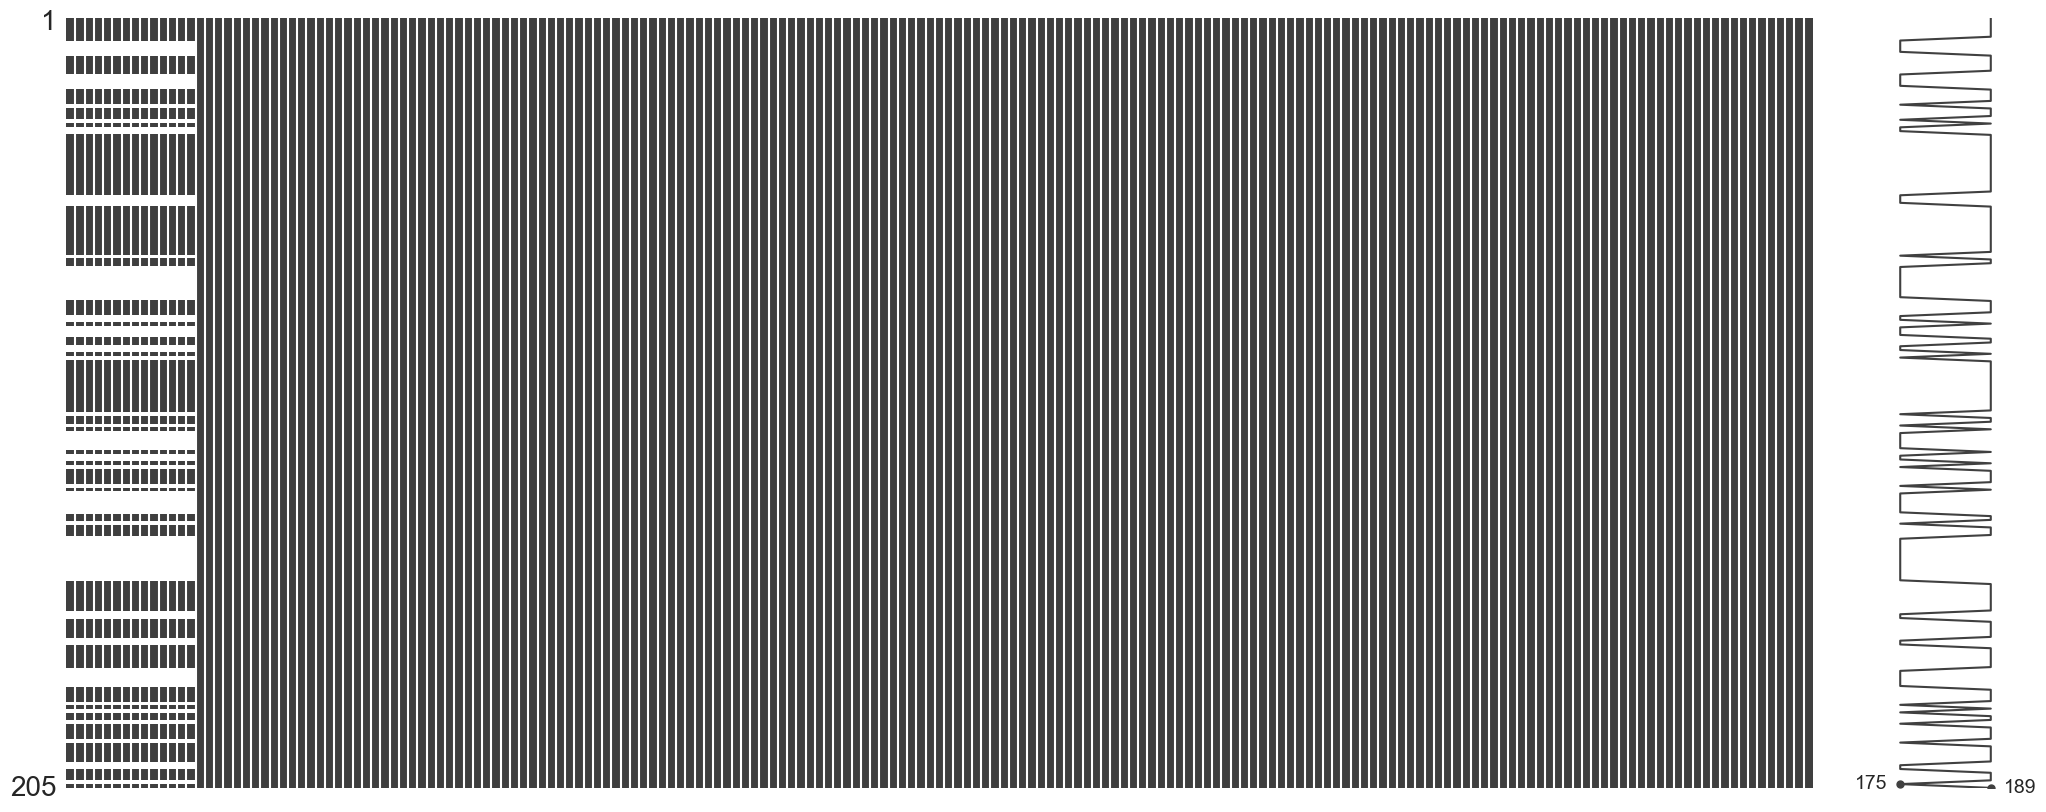

In [10]:
matrix(df)

In [11]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)


imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df_filled_original = scaler.inverse_transform(df_filled)
df = pd.DataFrame(df_filled_original, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Columns: 189 entries, symboling to fuelsystem_spfi
dtypes: float64(189)
memory usage: 302.8 KB


Корреляция признаков

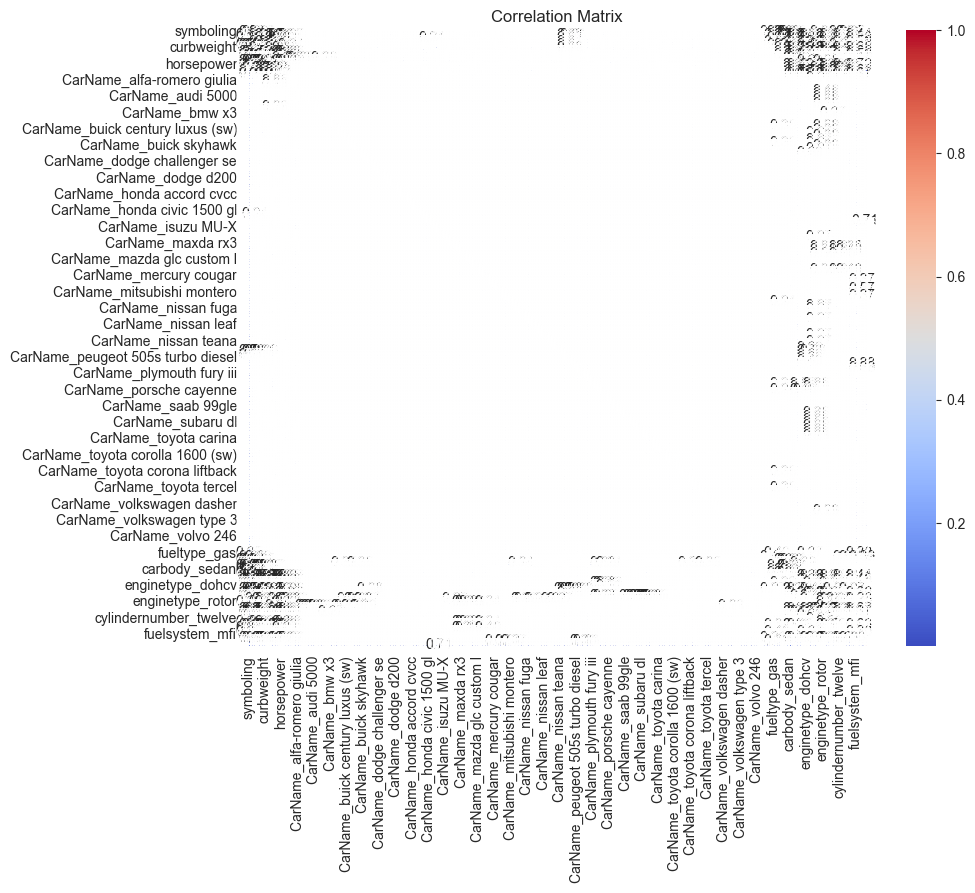

Удалённые колонки для сильно коррелирующих признаков
['carwidth', 'enginesize', 'horsepower', 'highwaympg', 'drivewheel_rwd', 'cylindernumber_three', 'cylindernumber_two', 'fuelsystem_idi', 'fuelsystem_mpfi']


In [12]:
correlation_matrix = df.corr().abs()

threshold = 0.7  # Порог корреляции 0.7

#Отбор сильно коррелирующих признаков
mask = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
collinear_features = [column for column in mask.columns if any(mask[column] > threshold)]

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

print("Удалённые колонки для сильно коррелирующих признаков")
print(collinear_features[1::2])

df = df.drop(columns=collinear_features[1::2])

Обучение модели

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2)

Линейная регрессия

In [14]:
linear_regression = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}
linear_regression_grid_search = GridSearchCV(linear_regression, param_grid, cv=kfold)
linear_regression_grid_search.fit(X_train, y_train)

best_model_linreg = linear_regression_grid_search.best_estimator_
y_pred = best_model_linreg.predict(X_test)

mse_score = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nСредняя оценка RMSE на тестовых данных для линейной регрессии:", np.sqrt(mse_score))
print("Средняя оценка R^2 на тестовых данных для линейной регрессии:", r2)

C:\Users\sagop\venv\lib\site-packages\scipy\optimize\_nnls.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=3.03989e-23): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
C:\Users\sagop\venv\lib\site-packages\scipy\optimize\_nnls.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=8.27522e-23): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
C:\Users\sagop\venv\lib\site-packages\scipy\optimize\_nnls.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=1.38388e-23): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
C:\Users\sagop\venv\lib\site-packages\scipy\optimize\_nnls.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=3.21652e-23): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
C:\Users\sagop\venv\lib\site-packages\scipy\optimize\_nnls.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=4.10807e-22): result may not be 


Средняя оценка RMSE на тестовых данных для линейной регрессии: 12286.642379829502
Средняя оценка R^2 на тестовых данных для линейной регрессии: -2.0625266924293526


C:\Users\sagop\venv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sagop\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sagop\venv\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_base.py", line 611, in fit
    self.coef_ = optimize.nnls(X, y)[0]
  File "C:\Users\sagop\venv\lib\site-packages\sci

Лассо регрессия

In [15]:
lasso = Lasso()

param_grid = {
    'alpha': [0.1, 1, 10],
    'max_iter': [1000, 5000],
    'selection': ['cyclic', 'random']
}

lasso_grid_search = GridSearchCV(lasso, param_grid=param_grid, cv=kfold)
lasso_grid_search.fit(X_train, y_train)

best_model_lasso = lasso_grid_search.best_estimator_
y_pred = best_model_lasso.predict(X_test)

mse_score = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nСредняя оценка RMSE на тестовых данных для лассо регрессии:", np.sqrt(mse_score))
print("Средняя оценка R^2 на тестовых данных для лассо регрессии:", r2)

C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+07, tolerance: 9.148e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+07, tolerance: 8.769e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e+07, tolerance: 7.606e+05
  


Средняя оценка RMSE на тестовых данных для лассо регрессии: 5357.191984333515
Средняя оценка R^2 на тестовых данных для лассо регрессии: 0.41777899722420075


Гребневая регрессия

In [16]:
ridge_regression = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10],
    'max_iter': [1000, 5000],
    'solver': ['svd', 'cholesky', 'sag', 'saga']
}

ridge_grid_search = GridSearchCV(ridge_regression, param_grid, cv=kfold)
ridge_grid_search.fit(X_train, y_train)

best_model_ridge = ridge_grid_search.best_estimator_
y_pred = best_model_ridge.predict(X_test)

mse_score = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nСредняя оценка RMSE на тестовых данных для гребневой регрессии:", np.sqrt(mse_score))
print("Средняя оценка R^2 на тестовых данных для гребневой регрессии:", r2)

C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the co


Средняя оценка RMSE на тестовых данных для гребневой регрессии: 5142.654231191475
Средняя оценка R^2 на тестовых данных для гребневой регрессии: 0.4634773044896372


C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elastic Net регрессия

In [17]:
elastic_net = ElasticNet()

param_grid = {
    'alpha': [0.1, 0.5, 1.0],  
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 
    'fit_intercept': [True, False]
}

elastic_grid_search = GridSearchCV(elastic_net, param_grid, cv=kfold)
elastic_grid_search.fit(X_train, y_train)

best_model_elastic = elastic_grid_search.best_estimator_
y_pred = best_model_elastic.predict(X_test)

mse_score = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nСредняя оценка RMSE на тестовых данных для Elastic Net регрессии:", np.sqrt(mse_score))
print("Средняя оценка R^2 на тестовых данных для Elastic Net регрессии:", r2)

C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e+09, tolerance: 3.237e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+09, tolerance: 3.161e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.162e+09, tolerance: 2.938e+06
  


Средняя оценка RMSE на тестовых данных для Elastic Net регрессии: 5161.314750804952
Средняя оценка R^2 на тестовых данных для Elastic Net регрессии: 0.45957661192349364


C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e+09, tolerance: 3.437e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+09, tolerance: 3.077e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\sagop\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.335e+08, tolerance: 3.963e+06
  

Первая модель нейронной сети

In [18]:
first_model = Sequential()
first_model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
first_model.add(Dropout(0.5))
first_model.add(Dense(32, activation='relu'))
first_model.add(Dropout(0.5))
first_model.add(Dense(1))

first_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = first_model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

predictions = first_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE первой нейронной сети: {rmse}')

Epoch 1/100
5/5 [==============================] - 7s 1s/step - loss: 228962432.0000 - root_mean_squared_error: 15131.5049 - val_loss: 171620112.0000 - val_root_mean_squared_error: 13100.3857
Epoch 2/100
5/5 [==============================] - 0s 44ms/step - loss: 223115424.0000 - root_mean_squared_error: 14937.0488 - val_loss: 163563952.0000 - val_root_mean_squared_error: 12789.2119
Epoch 3/100
5/5 [==============================] - 0s 40ms/step - loss: 208277280.0000 - root_mean_squared_error: 14431.8145 - val_loss: 154490304.0000 - val_root_mean_squared_error: 12429.4131
Epoch 4/100
5/5 [==============================] - 0s 33ms/step - loss: 200768384.0000 - root_mean_squared_error: 14169.2764 - val_loss: 144544896.0000 - val_root_mean_squared_error: 12022.6826
Epoch 5/100
5/5 [==============================] - 0s 28ms/step - loss: 194212496.0000 - root_mean_squared_error: 13936.0146 - val_loss: 134186464.0000 - val_root_mean_squared_error: 11583.8877
Epoch 6/100
5/5 [===============

Вторая модель нейронной сети

In [21]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32), 
                    activation='relu', 
                    kernel_regularizer=regularizers.l2(hp.Choice('l2_input', values=[0.01, 0.001, 0.0001]))))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(hp.Choice(f'l2_{i}', values=[0.01, 0.001, 0.0001]))))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,  # Можно изменить, если требуется
    directory='my_dir',  # Указать директорию для сохранения результатов
    project_name='regression_tuning'
)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.build(X_train.shape)  
best_model.summary()

_, test_rmse = best_model.evaluate(X_test, y_test)
print(f'RMSE второй нейронной сети: {test_rmse}')

Trial 5 Complete [00h 00m 13s]
val_loss: 34643828.0

Best val_loss So Far: 34643828.0
Total elapsed time: 00h 00m 40s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (164, 96)                 17376     
                                                                 
 dropout (Dropout)           (164, 96)                 0         
                                                                 
 dense_1 (Dense)             (164, 256)                24832     
                                                                 
 dropout_1 (Dropout)         (164, 256)                0         
                                                                 
 dense_2 (Dense)             (164, 1)                  257       
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
No

Гребневая регрессия оказалась наилучшей

In [25]:
df_test = pd.read_csv('CarPrice_Assignment.csv')
y_pred_test = best_model_ridge.predict(df)
results_df = pd.DataFrame()
results_df['id'] = df_test['car_ID']
 
results_df['Цена'] = y_pred_test
results_df.to_csv('sample.csv', index=False)

Вывод: добавил данные гребневой регрессии